In [1]:
%reset
%load_ext autoreload
%autoreload 2

Nothing done.


In [33]:
import numpy as np
from functions import loader, splt, fitter, stats
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from uncertainties import *
from uncertainties import unumpy as unp

savedir = "D05/"

In [8]:
all_data = loader.load_data( "../CloudVenetoAnalysisBis/20220611UngaussianityBySizeHighRes*/**/" )
data = all_data
# loader.remove_duplicates( all_data,
#     lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
#     lambda d: d['runned_replicas']
# )
len( data )

48

In [49]:
def G( thearray ):
    thearray = np.array( thearray )
    n = len( thearray )
    avg = np.mean( thearray )
    sum3 = np.sum( ( thearray - avg ) ** 3 ) / n
    sum232 = ( np.sum( ( thearray - avg ) ** 2 ) / n ) ** 1.5
    return np.sqrt( n * ( n - 1 ) ) / ( n - 2 ) * sum3 / sum232

def compute_in_decades( thearray, func ):
    tot_len = len( thearray )
    cluster_len = int( tot_len / 10 )
    results = []
    for i in range( 10 ):
        results.append( func( thearray[ cluster_len * i : cluster_len * ( i + 1 ) ] ) )
    return ufloat( func( thearray ), np.std( results ) )

In [51]:
for d in data:
    # x, y = fitter.rebin_width( d['h_x'], d['h'], 0.0002 )
    x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    d['fits'] = fitter.fits( x, y, d, plot=False )
    d['skew'] = skew( d['chunks'], bias=True )
    d['skew_u'] = compute_in_decades( d['chunks'], lambda c: skew( c, bias=True ) )
    d['G'] = G( d['chunks'] )
    d['G_u'] = compute_in_decades( d['chunks'], lambda c: G( c ) )
    d['npskew'] = ( np.mean( d['chunks'] ) - np.median( d['chunks'] ) ) / np.std( d['chunks'], ddof = 1 )
    d['npskew_u'] = compute_in_decades( d['chunks'], lambda c: ( np.mean( c ) - np.median( c ) ) / np.std( c, ddof = 1 ) )
    d['Z&S'] = np.sqrt( 2 * len( d['chunks'] ) ) * ( np.mean( d['chunks'] ) - np.median( d['chunks'] ) ) / np.std( d['chunks'], ddof = 1 )
    d['kurt'] = kurtosis( d['chunks'] )

filtered_data = data
len( filtered_data )

48

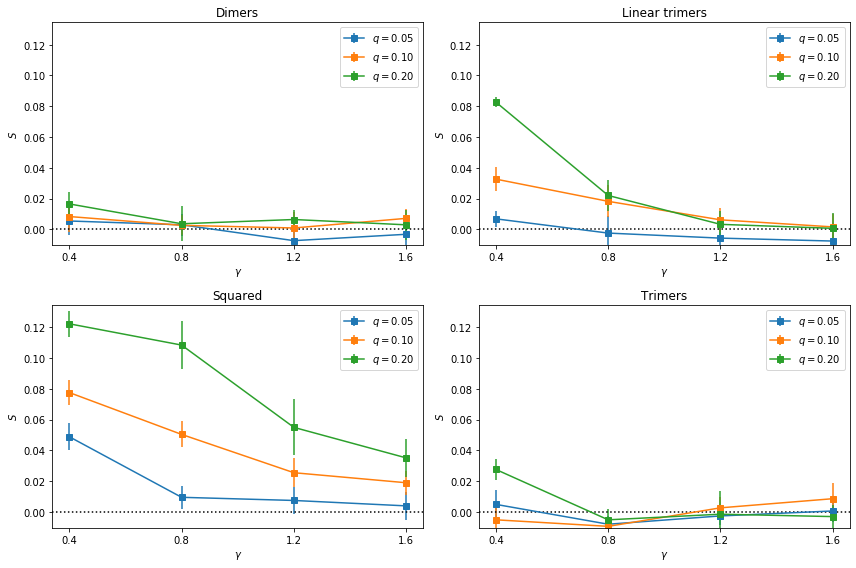

In [55]:
max = np.max( [ d['npskew'] for d in filtered_data ] )
min = np.min( [ d['npskew'] for d in filtered_data ] )

splt.oneitem_iterate_errorbar(
    len( filtered_data ),
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: filtered_data[d]['defects_frac'],
    lambda d: filtered_data[d]['side'],
    lambda d: [
        filtered_data[d]['npskew_u'],
    ],
    lambda it, l: [
        { 'label': fr"$q = {l:.2f}$", 'ls': '-', 'marker': 's'  }
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.ylim( np.min( [min * 1.1, min * 0.9] ), max * 1.1 ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"$Side$" ),
        splt.hline( 0 ),
        plt.ylabel( fr"$S$" )
    )
)

plt.tight_layout()
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.pdf" )
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.png" )